## Linear Model Trading Strategy Using Apple Stock

### 1. Simple Linear Model Using Past Log Returns

We assume a linear relationship between today's log return and a past log return:

$$
R_t = w \, R_{t-k} + b
$$

Predicted return:

$$
\hat{R}_t = w \, R_{t-k} + b
$$

Trading signal:

- Long if  
  $$
  \hat{R}_t > \text{threshold}
  $$

- Short if  
  $$
  \hat{R}_t \le \text{threshold}
  $$

---


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)


In [5]:
import pandas as pd
import numpy as np
import processing_data as pr
import feature_engineer as fe 
import data_generator as dg
import detect_and_handle_outlier as outlier


In [6]:
csv_path = r"C:\Users\ADMIN\Documents\Quantitative\Data\stocks_data\AAPL.csv"
SP_500_path = r"C:\Users\ADMIN\Documents\Quantitative\Data\S&P_500"
df_SP500 = pd.read_csv(SP_500_path)
df = pr.load_data(csv_path)
df

,date,ticker,adj_close,close,high,low,open,volume
0,2015-01-02,AAPL,24.237545,27.332500,27.860001,26.837500,27.847500,212818400.0
1,2015-01-05,AAPL,23.554737,26.562500,27.162500,26.352501,27.072500,257142000.0
2,2015-01-06,AAPL,23.556955,26.565001,26.857500,26.157499,26.635000,263188400.0
3,2015-01-07,AAPL,23.887274,26.937500,27.049999,26.674999,26.799999,160423600.0
4,2015-01-08,AAPL,24.805080,27.972500,28.037500,27.174999,27.307501,237458000.0
...,...,...,...,...,...,...,...,...
2697,2025-09-24,AAPL,252.065643,252.309998,255.740005,251.039993,255.220001,42303700.0
2698,2025-09-25,AAPL,256.621216,256.869995,257.170013,251.710007,253.210007,55202100.0
2699,2025-09-26,AAPL,255.212601,255.460007,257.600006,253.779999,254.100006,46076300.0
2700,2025-09-29,AAPL,254.183594,254.429993,255.000000,253.009995,254.559998,40127700.0


In [7]:
df_SP500['date'] = pd.to_datetime(df_SP500['date'])

In [8]:
df_SP500 = fe.add_lagged_log_returns(df_SP500, "close", no_max_lags=0)
df_SP500

,date,ticker,close,high,low,open,volume,close_log_return
0,2015-01-02,^GSPC,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,NaN
1,2015-01-05,^GSPC,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,-0.018447
2,2015-01-06,^GSPC,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,-0.008933
3,2015-01-07,^GSPC,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,0.011563
4,2015-01-08,^GSPC,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,0.017730
...,...,...,...,...,...,...,...,...
2697,2025-09-24,^GSPC,6637.970215,6672.660156,6621.759766,6669.790039,5459180000,-0.002851
2698,2025-09-25,^GSPC,6604.720215,6619.000000,6569.220215,6608.189941,5874670000,-0.005022
2699,2025-09-26,^GSPC,6643.700195,6648.970215,6604.430176,6615.379883,5103110000,0.005884
2700,2025-09-29,^GSPC,6661.209961,6677.310059,6644.490234,6661.580078,5358760000,0.002632


#### Preprocesing Data

- Sort & deduplicate
- Check OHLCV sanity
- Check missing value

In [9]:
df = pr.sort_and_deduplicate(df)
df_bad = pr.check_ohlcv_sanity(df)
df_bad

,date,ticker,adj_close,close,high,low,open,volume


In [10]:
pr.check_missing_values(df)

No Missing value


In [11]:
# add close log return
df = fe.add_lagged_log_returns(df, "close", no_max_lags=3).dropna().reset_index(drop=True)
df

,date,ticker,adj_close,close,high,low,open,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
0,2015-01-08,AAPL,24.805080,27.972500,28.037500,27.174999,27.307501,237458000.0,0.037703,0.013925,0.000094,-0.028576
1,2015-01-09,AAPL,24.831684,28.002501,28.312500,27.552500,28.167500,214798000.0,0.001072,0.037703,0.013925,0.000094
2,2015-01-12,AAPL,24.219810,27.312500,28.157499,27.200001,28.150000,198603200.0,-0.024949,0.001072,0.037703,0.013925
3,2015-01-13,AAPL,24.434855,27.555000,28.200001,27.227501,27.857500,268367600.0,0.008840,-0.024949,0.001072,0.037703
4,2015-01-14,AAPL,24.341742,27.450001,27.622499,27.125000,27.260000,195826400.0,-0.003818,0.008840,-0.024949,0.001072
...,...,...,...,...,...,...,...,...,...,...,...,...
2693,2025-09-24,AAPL,252.065643,252.309998,255.740005,251.039993,255.220001,42303700.0,-0.008367,-0.006464,0.042193,0.031531
2694,2025-09-25,AAPL,256.621216,256.869995,257.170013,251.710007,253.210007,55202100.0,0.017912,-0.008367,-0.006464,0.042193
2695,2025-09-26,AAPL,255.212601,255.460007,257.600006,253.779999,254.100006,46076300.0,-0.005504,0.017912,-0.008367,-0.006464
2696,2025-09-29,AAPL,254.183594,254.429993,255.000000,253.009995,254.559998,40127700.0,-0.004040,-0.005504,0.017912,-0.008367


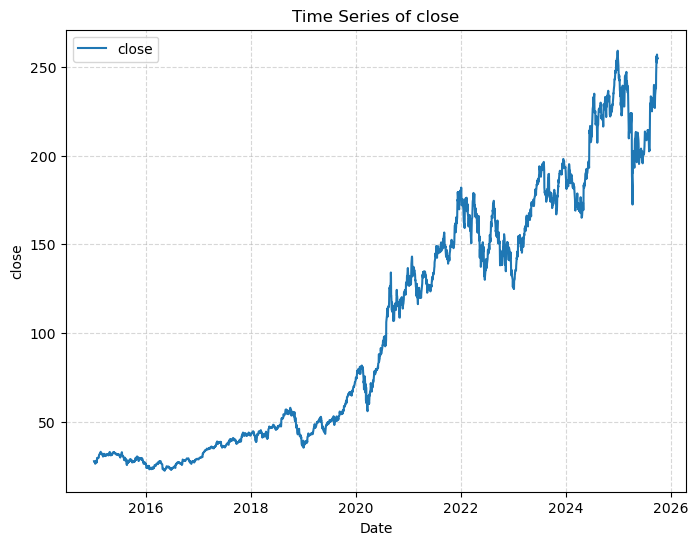

In [12]:
pr.plot_time_series(df, "close")

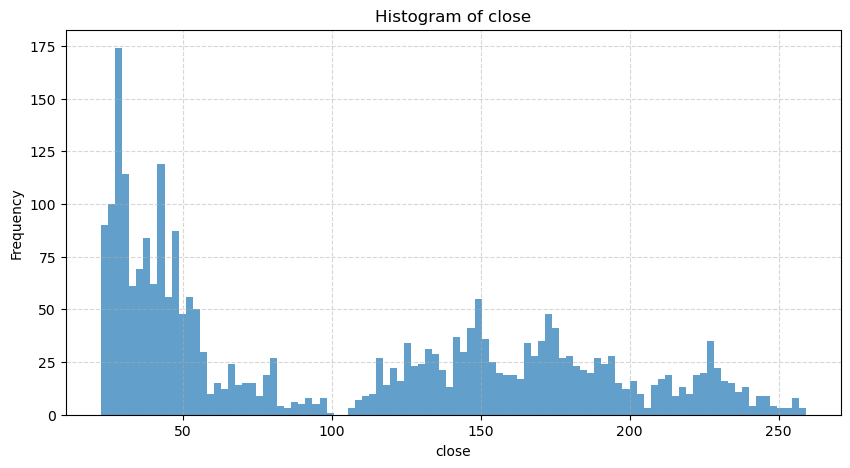

In [13]:
pr.histogram_distribution(df, "close", bins = 100)

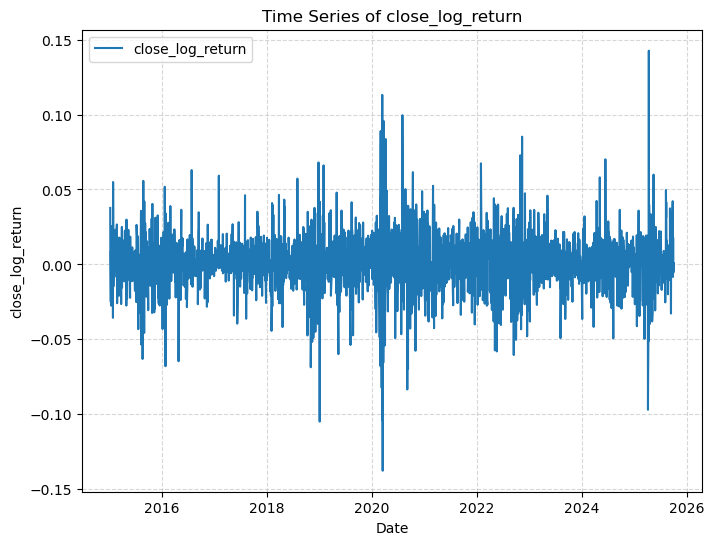

In [14]:
pr.plot_time_series(df, "close_log_return")

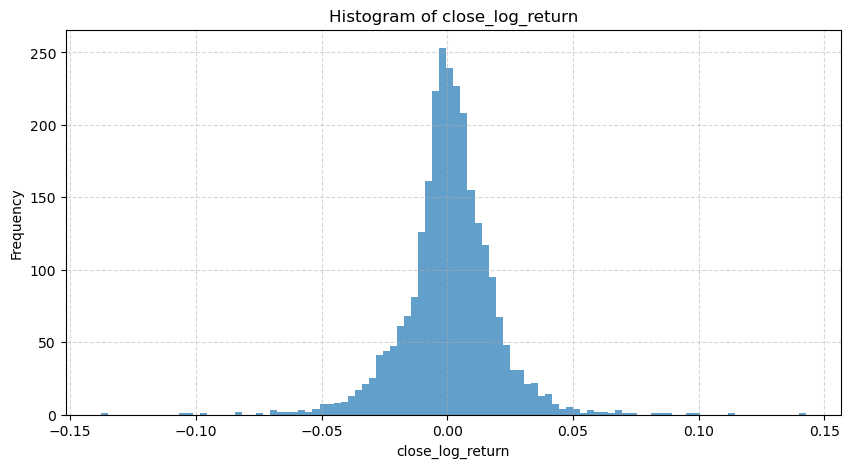

In [15]:
pr.histogram_distribution(df,"close_log_return", bins = 100)

In [16]:
# Correlation matrix
corr_matrix = df[["close_log_return", "close_log_return_lag_1", "close_log_return_lag_2","close_log_return_lag_3"]].corr()
corr_matrix

,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
close_log_return,1.000000,-0.054816,0.011761,-0.029669
close_log_return_lag_1,-0.054816,1.000000,-0.054822,0.011329
close_log_return_lag_2,0.011761,-0.054822,1.000000,-0.054808
close_log_return_lag_3,-0.029669,0.011329,-0.054808,1.000000


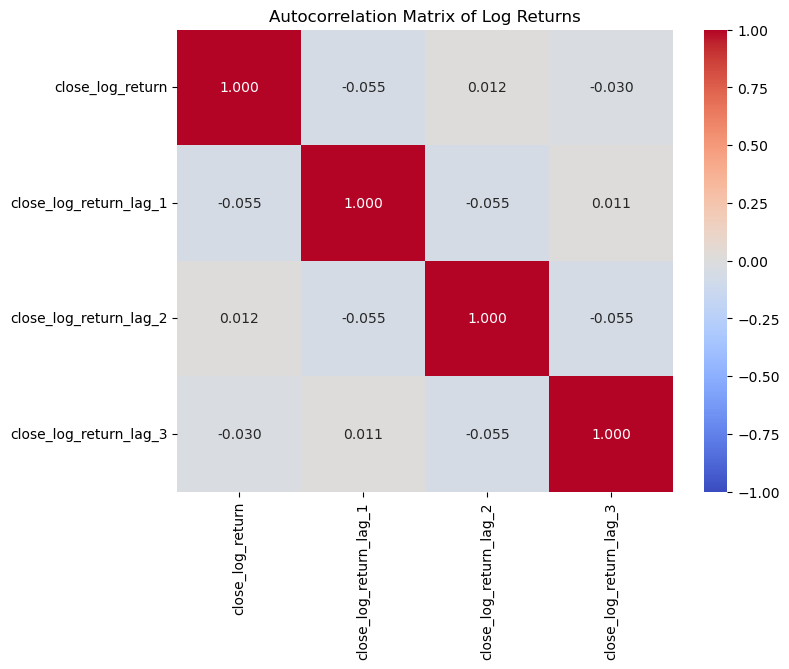

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'corr_matrix' is already calculated as per your code
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True,       # Show numeric values
            cmap='coolwarm',  # Red for pos, Blue for neg
            fmt=".3f",        # 3 decimal places
            vmin=-1, vmax=1)  # Fix scale to -1 and 1
plt.title("Autocorrelation Matrix of Log Returns")
plt.show()

We observe that close_log_return has the highest correlation with close_log_return_lag_1. Therefore, we include this lagged variable in our linear regression model.

In [18]:
df_model1 = df[["date", "close_log_return", "close_log_return_lag_1"]].copy()

In [19]:
import data_generator as dg

In [20]:
train_set, _, test_set = dg.vanilla_split_data(df_model1, train_size=0.8, val_size=0, test_size=0.2, purge_size=5)

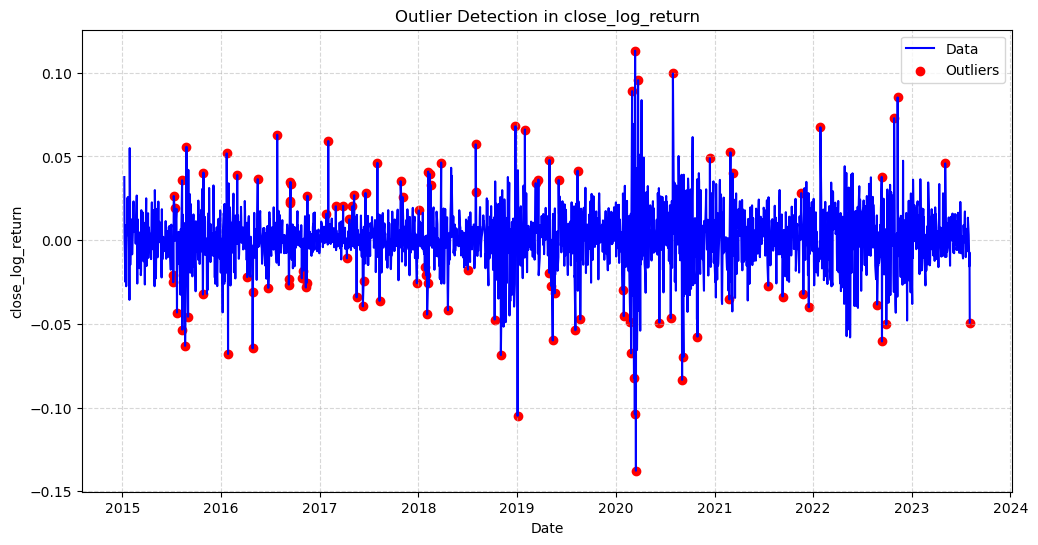

In [21]:
# Detect outlier using IQR

outlier.visualize_outliers(train_set, "close_log_return", method=outlier.detect_outliers_iqr, k=1.5, window_size = 30)


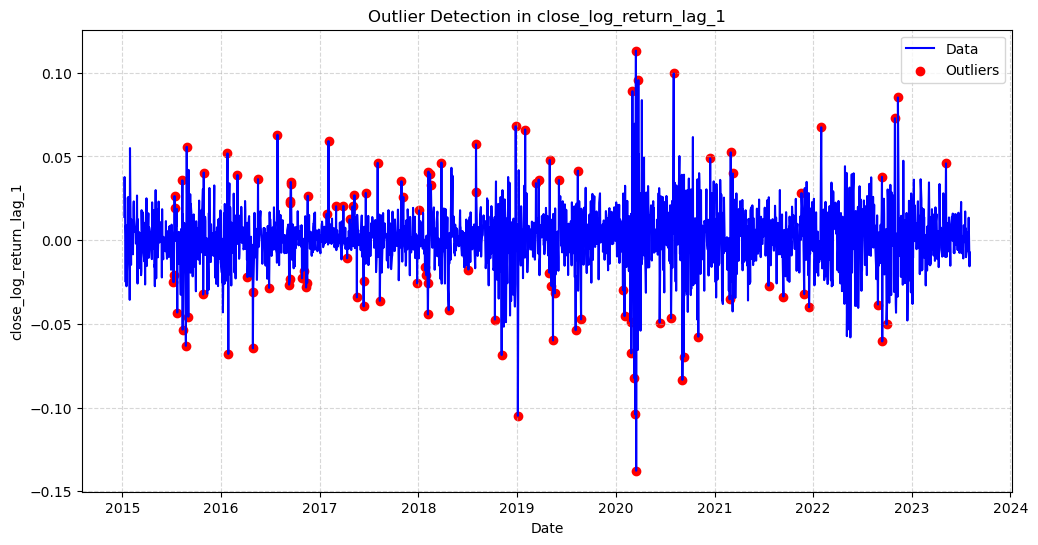

In [22]:
outlier.visualize_outliers(train_set, "close_log_return_lag_1", method=outlier.detect_outliers_iqr, k=1.5, window_size = 30)


In [27]:
# Hanlde outlier by using IQR
detected_train = outlier.detect_outliers_iqr(
    train_set,
    column="close_log_return_lag_1",
    k=1.5,
    window_size=30,
    lower_quartile=0.25,
    upper_quartile=0.75
)

X_train_clean = outlier.handle_outliers(
    train_set,
    column="close_log_return_lag_1",
    method=outlier.detect_outliers_iqr,
    k=1.5,
    window_size=30,
    lower_quartile=0.25,
    upper_quartile=0.75
)[["close_log_return_lag_1"]]



In [30]:
# Hanlde outlier by using winsorization 99% and 1% in Test set

lower_bound = detected_train["lower_bound"].min()   
upper_bound = detected_train["upper_bound"].max()

X_test_clean = test_set[["close_log_return_lag_1"]].clip(lower=lower_bound, upper=upper_bound)



In [31]:

y_train_clean = train_set["close_log_return"]
y_test_clean = test_set["close_log_return"]

### Build Linear Model

In [32]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_clean, y_train_clean)
y_hat = model.predict(X_test_clean)



In [33]:
trade_results = pd.DataFrame({
    "y_hat":y_hat,
    "y":y_test_clean})
trade_results

,y_hat,y
2163,0.001043,0.009349
2164,0.000192,-0.011264
2165,0.001886,-0.004971
2166,0.001369,-0.014662
2167,0.002165,0.002812
...,...,...
2693,0.001491,-0.008367
2694,0.001648,0.017912
2695,-0.000512,-0.005504
2696,0.001412,-0.004040


In [34]:
trade_results.count()

y_hat    535
y        535
dtype: int64

In [35]:
# Backtest strategy

trade_results["signal"] = np.sign(trade_results["y_hat"])
trade_results["signal"]

2163    1.0
2164    1.0
2165    1.0
2166    1.0
2167    1.0
       ... 
2693    1.0
2694    1.0
2695   -1.0
2696    1.0
2697    1.0
Name: signal, Length: 535, dtype: float64

In [36]:
trade_results[trade_results["signal"] == -1]

,y_hat,y,signal
2171,-0.000824,-0.026519,-1.0
2173,-0.000073,0.008807,-1.0
2175,-0.000813,0.018991,-1.0
2176,-0.000601,0.001172,-1.0
2188,-0.000418,0.006162,-1.0
...,...,...,...
2685,-0.000206,0.017411,-1.0
2686,-0.000471,0.011173,-1.0
2691,-0.001631,0.042193,-1.0
2692,-0.002507,-0.006464,-1.0


In [37]:
trade_results['signal'].value_counts()

signal
 1.0    430
-1.0    105
Name: count, dtype: int64

In [38]:
trade_results["is_won"] = np.where(np.sign(trade_results["y_hat"]) == np.sign(trade_results["y"]), 1, 0)
trade_results["is_won"]

2163    1
2164    0
2165    0
2166    0
2167    1
       ..
2693    0
2694    1
2695    1
2696    0
2697    1
Name: is_won, Length: 535, dtype: int64

In [39]:
trade_results["trade_log_return"] = (trade_results["signal"]*trade_results["y"])

In [40]:
trade_results["equity_curve"] = trade_results['trade_log_return'].cumsum()

In [41]:
trade_results["equity_curve"]

2163    0.009349
2164   -0.001914
2165   -0.006886
2166   -0.021548
2167   -0.018736
          ...   
2693   -0.310515
2694   -0.292604
2695   -0.287099
2696   -0.291139
2697   -0.290354
Name: equity_curve, Length: 535, dtype: float64

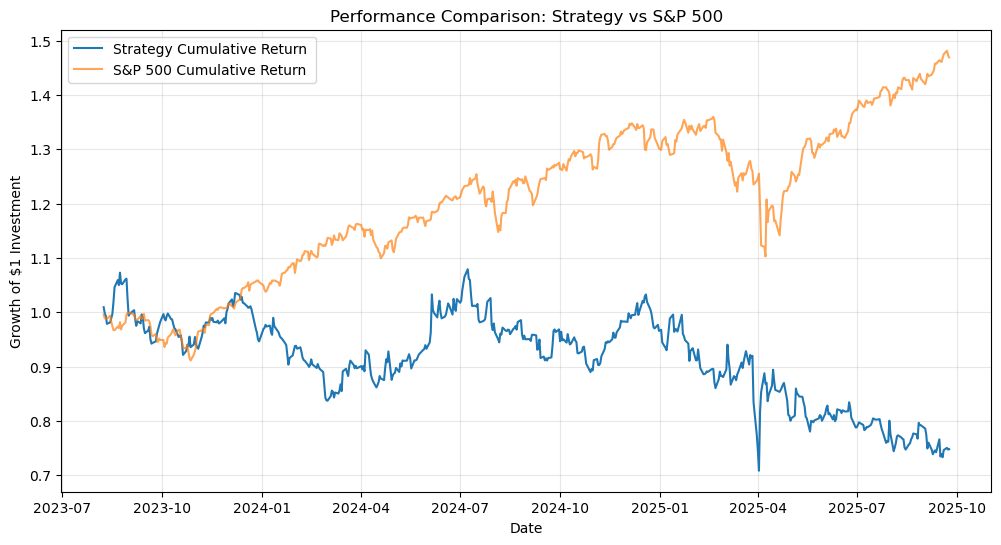

In [42]:
# Compare with S&P500

df_compare = pd.DataFrame()

df_compare['Strategy_Ret'] = trade_results['trade_log_return'] 
df_compare['Benchmark_Ret'] = df_SP500['close_log_return']
df_compare['date'] =  df_SP500['date']


df_compare.dropna(inplace=True)

df_compare['Strategy_Equity'] = np.exp(df_compare['Strategy_Ret'].cumsum())
df_compare['Benchmark_Equity'] = np.exp(df_compare['Benchmark_Ret'].cumsum())

plt.figure(figsize=(12, 6))
plt.plot(df_compare['date'], df_compare['Strategy_Equity'], label=f'Strategy Cumulative Return')
plt.plot(df_compare['date'], df_compare['Benchmark_Equity'], label=f'S&P 500 Cumulative Return ', alpha=0.7)

plt.title('Performance Comparison: Strategy vs S&P 500')
plt.ylabel('Growth of $1 Investment')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
import math

strategy_metrics = {
    "Win Rate": trade_results["is_won"].mean(),
    "Mean Log Return": trade_results["trade_log_return"].mean(),
    "Std Log Return": trade_results["trade_log_return"].std(),
    "Max Log Drawdown": (trade_results["equity_curve"] - trade_results["equity_curve"].cummax()).min(),
    "Sharpe Ratio": (trade_results["trade_log_return"].mean() / trade_results["trade_log_return"].std()) * math.sqrt(252)
}

# Metrics BENCHMARK (S&P 500)
sp500_log_ret = df_SP500["close_log_return"]
sp500_cum_ret = sp500_log_ret.cumsum()

benchmark_metrics = {
    # Win rate của thị trường là tỷ lệ số ngày tăng giá
    "Win Rate": (sp500_log_ret > 0).mean(),
    
    "Mean Log Return": sp500_log_ret.mean(),
    "Std Log Return": sp500_log_ret.std(),
    
    # Tính Drawdown cho Benchmark
    "Max Log Drawdown": (sp500_cum_ret - sp500_cum_ret.cummax()).min(),
    
    # Sharpe Ratio (Annualized)
    "Sharpe Ratio": (sp500_log_ret.mean() / sp500_log_ret.std()) * math.sqrt(252)
}

In [ ]:
#  Create DataFrame
comparison_df = pd.DataFrame([strategy_metrics, benchmark_metrics], index=["Strategy", "S&P 500"])

# Transpose 
comparison_df = comparison_df.T

print(comparison_df)


                  Strategy   S&P 500
Win Rate          0.489720  0.539230
Mean Log Return  -0.000552  0.000436
Std Log Return    0.017264  0.011380
Max Log Drawdown -0.431681 -0.414379
Sharpe Ratio     -0.507752  0.608676
